In [35]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set(style="darkgrid")
#import bayespy 

import pymc3 as pm
import arviz as az
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import ks_2samp

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
path = r'x:\CAO\Team\Client\BET\PerformanceLink\2021_05_Sistas S3\$Analysis\4. Model\Model Input\$ final model\tv_dig.csv'
data = pd.read_csv(path)

In [33]:
data.head()

,DIG_IMPS,TV_IMPS,TOTAL_CONV
0,0.0,1.0,6
1,0.0,1.0,4
2,0.0,8.0,0
3,0.0,10.0,6
4,0.0,6.0,0


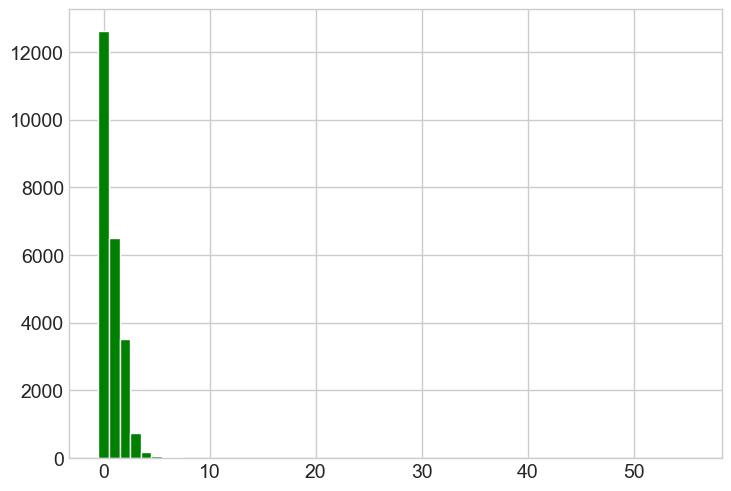

In [34]:
plt.bar(data.TOTAL_CONV.value_counts().index, data.TOTAL_CONV.value_counts(), width=1, color = 'green')
plt.show()

In [5]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

In [19]:
with pm.Model() as model_negative_binomial:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd = 10, shape = len(data.columns[:-1]))
        # Error term
        eps = pm.Gamma('eps', alpha = 1, beta = 0.5)
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        # Likelihood
        conv = pm.NegativeBinomial('conv', 
                                   mu = mu, 
                                   alpha= eps,  
                                   observed=y)
        pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
        trace_negative_binomial = pm.sample(chains = 2, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 251 seconds.


posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


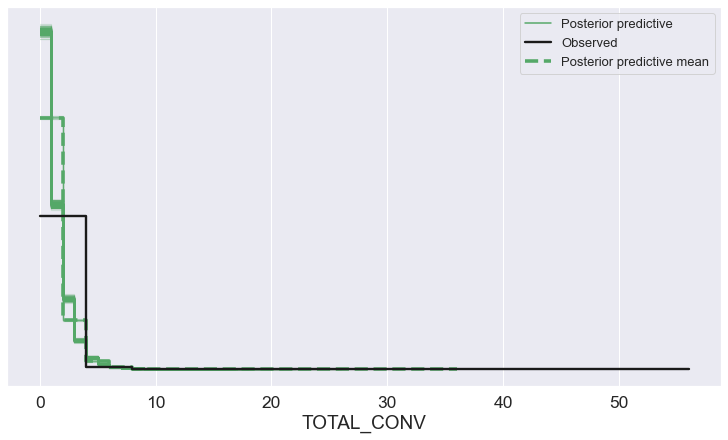

R2 for Model is : 0.031


In [20]:
predictions_negative_binomial = ppc_check(model = model_negative_binomial, 
                            data = data, 
                            trace = trace_negative_binomial, 
                            predictions= True)

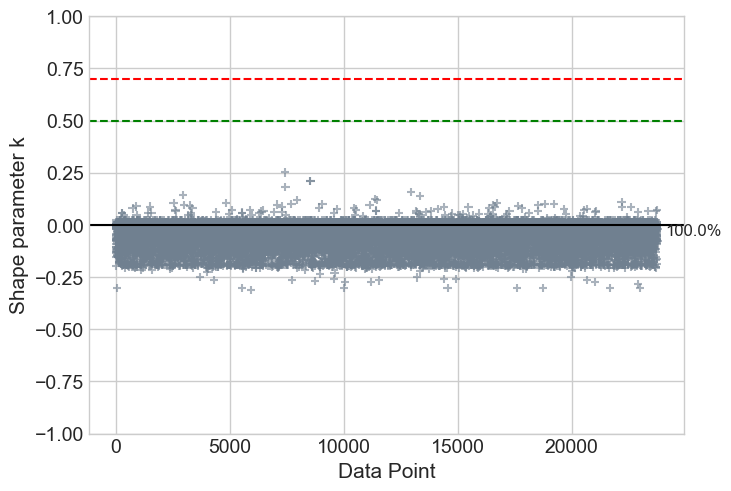

In [21]:
# compute with arviz InferenceData type
p_loo_zinb = pm.loo(trace_negative_binomial, pointwise=True, var_name='conv')

# plot khat diagnostic
plt.style.use("arviz-whitegrid")
pm.plot_khat(p_loo_zinb, show_bins=True, color='slategray', alpha=0.6)
plt.axhline(0.5, color = 'green', linestyle='dashed')
plt.axhline(0.7, color = 'red', linestyle='dashed')
plt.axhline(0, color='black')
plt.ylim((-1, 1))
plt.show()

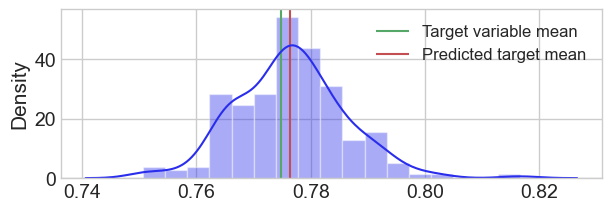

In [27]:
samples_mean = [sample.mean() for sample in predictions_negative_binomial['conv']]

plt.figure(figsize=(6,2))
ax = sns.distplot(samples_mean,)
plt.vlines(y.mean(), *ax.set_ylim(), color='g', label='Target variable mean')
plt.vlines(predictions_negative_binomial['conv'].flatten().mean(), 
           *ax.set_ylim(),
           label='Predicted target mean',  
           color='r')
plt.legend(loc=1, fontsize ='medium')
plt.show()

In [28]:
az.summary(trace_negative_binomial, var_names='beta')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.001,0.001,0.000,0.004,0.0,0.0,1668.0,836.0,1.0
beta[1],0.002,0.000,0.001,0.002,0.0,0.0,1129.0,1351.0,1.0
